<a href="https://colab.research.google.com/github/BradenEberhard/LoanDefaultPrediction/blob/main/Loan_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Things to try


1.  PCA
2.  ICA
3.  classify then regress



# Setup



In [ ]:
from google.colab import files
import io
import pandas as pd
import numpy as np
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
import math
import gc
import seaborn as sn
from tqdm import tqdm
import xgboost as xgb
from sklearn.decomposition import NMF
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Read in Data

In [ ]:
full_data = pd.read_csv('./drive/MyDrive/Models/FullDefaultData.csv')
full_data.head()

,f9,f10,f13,f14,f15,f16,f17,f18,f19,f20,f22,f23,f24,f25,f26,f27,f28,f29,f30,f32,f36,f43,f44,f45,f47,f48,f53,f54,f55,f57,f58,f59,f61,f62,f63,f65,f66,f75,f78,f82,...,f579,f581,f582,f583,f587,f594,f595,f596,f597,f598,f599,f609,f611,f612,f616,f617,f618,f619,f627,f628,f629,f630,f632,f633,f634,f638,f639,f640,f646,f669,f673,f674,f675,f761,f762,f763,f765,f766,loss,Set
0,126.75,126.03,7,0.7607,0.7542,612922,0.7236,0.7236,0.5171,0.7236,0.7876,1.097851e+09,89,66,998046.0,89.0,89.0,89.00,89.00,0.9271,5,0.026826,1.037424,0.83380,0.825920,5.0,0.013870,2.661469,0.53855,0.551920,5.0,0.79380,0.794880,5.0,0.95355,0.960160,0.025156,5.11,43501.0,0.51,...,462.61,3.814434e+09,4949.0,4.460000e+12,-0.03,0.0026,0.0,2.430,5,2.412,5,0.852665,6.094447,1.480921,0.0,0.0,0.54,0.15,1.602703e+37,1.591695e+08,0.2320,0.3276,0.929,5.0,0.261,0.38291,1.09449,94.417,0.575607,3.3993,15.41,33,3.0,4.4352,4.2676,-0.1524,-0.40,-0.560,0.0,train
1,123.52,121.35,7,0.6555,0.6555,245815,0.6341,0.6341,0.3909,0.6667,0.6903,8.449459e+08,78,50,754416.0,78.0,78.0,78.00,78.00,0.8478,6,0.107658,-0.915138,0.72515,0.687067,6.0,0.112048,-0.812372,0.42545,0.393817,6.0,0.71515,0.669100,6.0,0.85390,0.793950,0.142922,4.19,1464.0,0.02,...,93.77,6.255937e+07,1625.0,1.548914e+10,-0.15,0.0004,0.0,2.430,5,2.412,5,0.916957,6.222813,1.460848,0.0,0.0,1.00,0.11,7.158934e+36,2.810548e+08,0.7440,0.6852,6.548,6.0,11.219,1.05606,1.32876,86.005,-1.050590,2.4875,13.90,43,10.0,3.2763,2.7962,-0.3097,-0.17,-0.275,0.0,train
2,127.76,126.49,7,0.7542,0.7542,1385872,0.7542,0.7542,0.5508,0.7542,0.7807,1.308478e+09,89,54,1037651.0,89.0,89.0,100.43,94.37,0.9175,13,0.208224,-1.332533,0.80455,0.709346,13.0,0.208174,-1.336869,0.54540,0.502138,13.0,0.78035,0.692523,13.0,0.88875,0.798423,0.254750,4.72,12951.0,0.01,...,108.60,7.546793e+07,1527.0,2.161441e+10,0.03,0.0029,0.0,2.430,5,2.412,5,0.881415,6.939924,1.528423,0.0,0.0,0.05,0.00,5.602792e+37,3.411370e+08,0.5760,0.4848,11.148,13.0,16.775,1.00346,1.28496,88.168,-1.322173,4.3000,-0.42,100,5.0,8.1381,7.3269,-0.1909,-0.58,-0.540,0.0,train
3,132.94,133.58,7,0.8017,0.7881,704687,0.7881,0.7881,0.5923,0.7881,0.8158,1.472752e+09,93,55,1115721.0,93.0,93.0,114.63,102.92,0.9688,4,0.043725,-0.947279,0.81150,0.800900,4.0,0.045525,-1.121228,0.58615,0.573525,4.0,0.80790,0.797550,4.0,0.95440,0.928550,0.067230,6.35,45062.0,0.01,...,127.84,1.213356e+08,1730.0,4.083335e+10,-0.03,0.0004,0.0,2.430,5,2.412,5,0.982108,5.914965,1.538623,0.0,0.0,3.79,1.66,2.436205e+37,1.674241e+08,0.2460,0.1468,1.496,4.0,1.120,0.99047,1.21535,87.051,-0.910821,0.0000,5.63,18,2.0,3.2516,3.0631,-0.1770,-0.75,-0.635,0.0,train
4,122.72,112.77,6,0.5263,0.5263,51985,0.5263,0.5263,0.3044,0.5405,0.5455,1.442916e+09,60,21,536400.0,60.0,60.0,60.00,60.00,0.8451,26,0.062251,-0.950251,0.71780,0.810285,26.0,0.070823,-0.807304,0.37220,0.483685,26.0,0.66275,0.779285,26.0,0.86255,0.870969,0.075199,2.78,564.0,0.26,...,20.80,8.847910e+05,491.0,4.752826e+07,-0.35,0.0092,0.0,2.845,6,2.535,6,1.215206,6.059663,1.694474,0.0,0.0,0.02,0.00,5.501700e+38,4.304878e+08,0.5595,0.5831,18.154,26.0,17.739,0.90136,1.31550,72.670,-0.547161,9.8523,3.80,33,9.0,17.5561,15.6079,-0.4444,-0.18,-0.280,0.0,train


In [ ]:
train = pd.read_csv('./drive/MyDrive/Models/train_v2.csv', index_col=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (135,204,274,417) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


See Data

In [ ]:
print('shape' + str(train.shape))
train.describe()
over_0_vals = train.loc[train['loss'] > 0]
over_sampled = pd.concat([over_0_vals] * 5)


shape(105471, 770)


Clean Data

In [ ]:
##drop f466 and NA loss
train = train[train['loss'].notna()]
train = train.drop('f466',axis=1, inplace=False)
##replace all NAs with -1
train = train.replace([np.inf, -np.inf], np.nan, inplace=False) 
train = train.replace('NA', -1)
train = train.fillna(-1)
##make object vals floats
train.loc[:,train.select_dtypes(include='object').columns] = train.loc[:,train.select_dtypes(include='object').columns].astype(float)

##remove zero var and scale all features
zv = VarianceThreshold(threshold=(0.001))    
zv.fit(train)
train = train[train.columns[zv.get_support(indices=True)]]
print('new train shape:' + str(train.shape))

new train shape:(105471, 751)


In [ ]:
##drop f466 and NA loss
over_sampled = over_sampled[over_sampled['loss'].notna()]
over_sampled = over_sampled.drop('f466',axis=1, inplace=False)
##replace all NAs with -1
over_sampled = over_sampled.replace([np.inf, -np.inf], np.nan, inplace=False) 
over_sampled = over_sampled.replace('NA', -1)
over_sampled = over_sampled.fillna(-1)
##make object vals floats
over_sampled.loc[:,over_sampled.select_dtypes(include='object').columns] = over_sampled.loc[:,over_sampled.select_dtypes(include='object').columns].astype(float)

##remove zero var and scale all features

over_sampled = over_sampled[over_sampled.columns[zv.get_support(indices=True)]]
print('new train shape:' + str(over_sampled.shape))

new train shape:(48915, 751)


Helper Functions

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

def write_tensor_to_csv(tensor, name):
  x = pd.DataFrame(tensor, index=test.index, columns=['loss']).astype(float)
  x.index.name = 'id'
  x.to_csv('./{}.csv'.format(name))
  return True

def clamp(n, minn, maxn):
    return max(min(maxn, n), minn)

# Data Sets

In [ ]:
class data(Dataset):
  def __init__(self, data_df, label_df):
    self.data = df_to_tensor(data_df)
    self.labels = df_to_tensor(label_df)

  def __len__(self):
    return(len(self.data))

  def __getitem__(self, idx):
    return self.data[idx,], self.labels[idx]

# Models

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self, batch_size = 10, num_features = 770, hidden_layer_nodes = 300, restricted_layer_nodes = 75):
    super(AutoEncoder, self).__init__()
    self.batch_size = batch_size
    self.num_features = num_features
    self.hidden_layer_nodes = hidden_layer_nodes
    self.restriced_layer_nodes = restricted_layer_nodes

    self.relu = nn.ReLU()
    self.norm1 = nn.BatchNorm1d(hidden_layer_nodes)
    self.norm2 = nn.BatchNorm1d(restricted_layer_nodes)
    self.encoder1 = nn.Linear(in_features=num_features, out_features=hidden_layer_nodes)
    self.encoder2 = nn.Linear(in_features=hidden_layer_nodes, out_features=restricted_layer_nodes)
    self.decoder1 = nn.Linear(in_features=restricted_layer_nodes, out_features=hidden_layer_nodes)
    self.decoder2 = nn.Linear(in_features=hidden_layer_nodes, out_features=num_features)

  def forward(self, x):
    encoder_out = self.relu(self.norm2(self.encoder2(self.relu(self.norm1(self.encoder1(x))))))
    decoder_out = self.decoder2(self.relu(self.norm1(self.decoder1(encoder_out))))
    return encoder_out, decoder_out


In [ ]:
class Standard_Model(nn.Module):
  def __init__(self, batch_size = 10, num_features = 770):
    super(Standard_Model, self).__init__()
    self.batch_size = batch_size
    self.num_features = num_features

    self.relu = nn.ReLU()
    self.firstLayer = nn.Linear(in_features = num_features, out_features=num_features)
    self.secondLayer = nn.Linear(in_features=num_features, out_features=num_features)
    self.finalLayer = nn.Linear(in_features=num_features, out_features=1)
    self.dropout = nn.Dropout(p=0.7)
    self.norm = nn.BatchNorm1d(num_features=num_features)

  def forward(self, x):
    out1 = self.dropout(self.relu(self.norm(self.firstLayer(x))))
    out2 = self.dropout(self.relu(self.norm(self.secondLayer(out1))))
    out3 = self.relu(self.finalLayer(out2))
    return out3


In [ ]:
class Standard_Model_Classifier(nn.Module):
  def __init__(self, batch_size = 10, num_features = 770):
    super(Standard_Model_Classifier, self).__init__()
    self.batch_size = batch_size
    self.num_features = num_features

    self.relu = nn.ReLU()
    self.firstLayer = nn.Linear(in_features = num_features, out_features=num_features)
    self.secondLayer = nn.Linear(in_features=num_features, out_features=num_features)
    self.finalLayer = nn.Linear(in_features=num_features, out_features=2)
    self.dropout = nn.Dropout(p=0.7)
    self.norm = nn.BatchNorm1d(num_features=num_features)
    nn.init.xavier_uniform(self.firstLayer.weight)
    nn.init.xavier_uniform(self.secondLayer.weight)
    nn.init.xavier_uniform(self.finalLayer.weight)

  def forward(self, x):
    out1 = self.dropout(self.relu(self.norm(self.firstLayer(x))))
    out2 = self.dropout(self.relu(self.norm(self.secondLayer(out1))))
    out3 = self.relu(self.finalLayer(out2))
    return out3

# Training Loop

Loop for Classification

In [ ]:
BATCH_SIZE = 100
LEARNING_RATE = 1e-3
NUM_EPOCHS = 50

y = (train.loc[:,'loss'] != 0).astype(int)
X = train.drop(['loss'], axis=1, inplace=False)
scaler = StandardScaler()
X = train.drop(['loss'], axis=1, inplace=False)
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

def scope():
  try:
    gc.collect()
    my_train_data = data(X_train, y_train)
    train_loader = DataLoader(my_train_data, batch_size = BATCH_SIZE, shuffle = True)

    model = Standard_Model_Classifier(batch_size = BATCH_SIZE, num_features = X_train.shape[1]).cuda()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    batch_losses = []
    epoch_losses = []
    accuracies_train = []
    val_losses = []
    accuracies = []


    for epoch in range(NUM_EPOCHS):
      loop = tqdm(total=len(train_loader), position=0, leave=False)

      for batch, (x, y_truth) in enumerate(train_loader):
        x, y_truth = x.cuda(non_blocking = True), y_truth.cuda(non_blocking = True)
        optimizer.zero_grad()
        y_hat = model(x).squeeze()
        cel = criterion(y_hat, y_truth.long())
        cel.backward()
        batch_losses.append(cel.item())
        optimizer.step()

        loop.set_description('epoch:{} loss:{:4f} batch:{:4f} mem:{:2f}'.format(epoch, cel.item(), batch, torch.cuda.memory_allocated()/1e9))
        loop.update(1)

      loop.close()
      x_val, y_truth_val = df_to_tensor(X_test).cuda(non_blocking = True), df_to_tensor(y_test).cuda(non_blocking = True)
      y_hat_val = model(x_val).squeeze()
      accuracy = (y_truth_val ==  torch.argmax(y_hat_val, 1)).sum()
      accuracies.append(accuracy)
      val_losses.append(cel.item())


      epoch_losses.append(np.mean(batch_losses))
      batch_losses.clear()
  except:
    gc.collect()
    __ITB__()
    

  return epoch_losses, val_losses, model, accuracies
epoch_losses, val_losses, final_model, accuracies = scope()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app


Loop for regression

In [ ]:
BATCH_SIZE = 100
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100



over_sampled_y = over_sampled.loc[:,'loss']
y = train.loc[:,'loss']
scaler = StandardScaler()
X = train.drop(['loss'], axis=1, inplace=False)
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)
over_sampled_X = over_sampled.drop(['loss'], axis = 1, inplace = False)
over_sampled_X= pd.DataFrame(scaler.transform(over_sampled_X), columns=over_sampled_X.columns)

scaled_y = np.array(y).reshape(-1,1)
loss_scaler = StandardScaler()
loss_scaler.fit(scaled_y)
scaled_y = pd.DataFrame(loss_scaler.transform(scaled_y), columns=['loss'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = pd.concat([X_train, over_sampled_X])
y_train = pd.concat([y_train, over_sampled_y])

y = full_data.loc[full_data['Set'] == 'train'].loc[:,'loss']
X_full = full_data.loc[full_data['Set'] == 'train'].drop(['loss', 'Set'], axis=1, inplace=False)
scaler = StandardScaler()
scaler.fit(X_full)
X_full = pd.DataFrame(scaler.transform(X_full), columns=X_full.columns)
X = pd.DataFrame(scaler.transform(X_full), columns=X_full.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
def scope():
  try:
    gc.collect()


    my_train_data = data(X_train, y_train)
    train_loader = DataLoader(my_train_data, batch_size = BATCH_SIZE, shuffle = True)

    model = Standard_Model(batch_size = BATCH_SIZE, num_features = X_train.shape[1]).cuda()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.L1Loss()

    batch_losses = []
    epoch_losses = []
    accuracies_train = []
    val_losses = []


    for epoch in range(NUM_EPOCHS):
      loop = tqdm(total=len(train_loader), position=0, leave=False)

      for batch, (x, y_truth) in enumerate(train_loader):
        x, y_truth = x.cuda(non_blocking = True), y_truth.cuda(non_blocking = True)
        optimizer.zero_grad()
        y_hat = model(x).squeeze()
        mae = criterion(y_truth, y_hat)
        
        mae.backward()
        batch_losses.append(mae.item())
        optimizer.step()

        loop.set_description('epoch:{} loss:{:4f} batch:{:4f} mem:{:2f}'.format(epoch, mae.item(), batch, torch.cuda.memory_allocated()/1e9))
        loop.update(1)

      loop.close()
      x_val, y_truth_val = df_to_tensor(X_test).cuda(non_blocking = True), df_to_tensor(y_test).cuda(non_blocking = True)
      y_hat_val = model(x_val).squeeze()
      mae = criterion(y_truth_val, y_hat_val)
      val_losses.append(mae.item())


      epoch_losses.append(np.mean(batch_losses))
      batch_losses.clear()
  except:
    gc.collect()
    __ITB__()

  return epoch_losses, val_losses, model
epoch_losses, val_losses, final_model = scope()

In [ ]:
X_full_test = full_data.loc[full_data['Set'] == 'test'].drop(['loss', 'Set'], axis=1, inplace=False)
scaler = StandardScaler()
scaler.fit(X_full_test)
X_full_test = pd.DataFrame(scaler.transform(X_full_test), columns=X_full_test.columns)
y_hat_val = final_model(df_to_tensor(X_full_test)).squeeze()
x = pd.DataFrame(y_hat_val, columns=['loss']).astype(int)
x.index += 105472
x.index.name = 'id'
x.to_csv('./output.classic_full.csv')
x.describe()

,loss
count,210944.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


Autoencoder loop

In [ ]:
def load_model():
  checkpoint = torch.load('./drive/MyDrive/Models/loan_prediction')
  return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict']


In [ ]:
BATCH_SIZE = 100
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5

y = full_data.loc[full_data['Set'] == 'train'].loc[:,'loss']
X_full = full_data.loc[full_data['Set'] == 'train'].drop(['loss', 'Set'], axis=1, inplace=False)
scaler = StandardScaler()
scaler.fit(X_full)
X_full = pd.DataFrame(scaler.transform(X_full), columns=X_full.columns)
X_train = train.drop(['loss'], axis=1, inplace=False)
scaler = StandardScaler()
scaler.fit(X_train)
X = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

def scope():
  try:
    gc.collect()
    my_train_data = data(X_full, y)
    train_loader = DataLoader(my_train_data, batch_size = BATCH_SIZE, shuffle = True)

    model = AutoEncoder(batch_size = BATCH_SIZE, num_features = X_full.shape[1]).cuda()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()

    batch_losses = []
    e, m, o = load_model()
    model.load_state_dict(m)
    optimizer.load_state_dict(o)

    for epoch in range(NUM_EPOCHS):
      epoch = epoch + e
      loop = tqdm(total=len(train_loader), position=0, leave=False)

      for batch, (x, y_truth) in enumerate(train_loader):
        x, y_truth = x.cuda(non_blocking = True), y_truth.cuda(non_blocking = True)
        optimizer.zero_grad()
        encoder_out, reconstructed_input = model(x)
        mse = criterion(reconstructed_input, x)
        mse.backward()
        batch_losses.append(mse.item())
        optimizer.step()

        loop.set_description('epoch:{} loss:{:4f} batch:{:4f} mem:{:2f}'.format(epoch, mse.item(), batch, torch.cuda.memory_allocated()/1e9))
        loop.update(1)


      loop.close()
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),

            }, './drive/MyDrive/Models/loan_prediction')

  except:
    gc.collect()
    __ITB__()

  return batch_losses, model
batch_losses, final_model = scope()

(tensor([[3.3268, 2.3487, 4.8880,  ..., 3.4257, 2.5696, 3.5360],
         [3.6671, 2.2859, 5.6712,  ..., 2.4266, 1.5807, 3.8562],
         [3.4454, 2.2981, 4.8264,  ..., 2.5584, 3.5024, 3.1406],
         ...,
         [3.0520, 2.3536, 6.6620,  ..., 2.9402, 1.2264, 2.8193],
         [3.1522, 2.4426, 4.6206,  ..., 2.9428, 3.3977, 1.9526],
         [2.4468, 2.1464, 6.4731,  ..., 2.2743, 4.4594, 3.5743]],
        device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([[-0.3152, -0.2246,  0.1660,  ...,  0.3351,  0.0396,  1.2250],
         [ 1.6326,  1.6158,  0.3577,  ..., -0.2562,  0.7029,  0.0683],
         [-0.3514, -0.3429,  0.5326,  ...,  0.6714, -1.1403, -1.3245],
         ...,
         [ 1.3237,  1.2701, -0.5434,  ...,  0.3104, -0.2580,  0.4497],
         [-0.3127, -0.1443, -0.5525,  ...,  0.8550, -0.8189, -1.1864],
         [ 2.2286,  2.3982, -0.3394,  ..., -3.2657,  1.9774,  0.4718]],
        device='cuda:0', grad_fn=<AddmmBackward>))

Graphs

Text(0, 0.5, 'MSE')

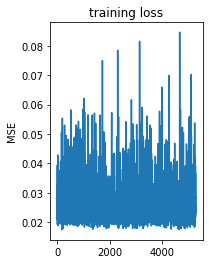

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(batch_losses)
plt.title('training loss')
plt.ylabel('MSE')


plt.subplot(1, 2, 2)
plt.plot(val_losses)
plt.title('testing loss')
plt.ylabel('L1 Loss')
plt.tight_layout()
plt.show()

# NMF decomp




In [ ]:
model = NMF(n_components=75, init='random', random_state=0)

y = full_data.loc[full_data['Set'] == 'train'].loc[:,'loss']
X_full = full_data.loc[full_data['Set'] == 'train'].drop(['loss', 'Set'], axis=1, inplace=False)
scaler = MinMaxScaler()
scaler.fit(X_full)
X_full = pd.DataFrame(scaler.transform(X_full), columns=X_full.columns)

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=test_size, random_state=seed)

nmf = model.fit(X_train)
W = nmf.transform(X_train)
H = nmf.components_

model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 50, alpha = 10, n_estimators = 10)
model.fit(W, y_train)

# make predictions for test data
W_hat = nmf.transform(X_test)
y_pred = model.predict(W_hat)
predictions = y_pred


# evaluate predictions
criterion = nn.L1Loss()
mse = mean_absolute_error(y_test, predictions)
print("MSE: %f" % mse)


MSE: 1.325635


In [ ]:
##do testing data and output results
X_full_test = full_data.loc[full_data['Set'] == 'test'].drop(['loss', 'Set'], axis=1, inplace=False)
X_full_test = pd.DataFrame(scaler.transform(X_full_test), columns=X_full.columns)
X_full_test = X_full_test * (X_full_test > 0)
W_final = nmf.transform(X_full_test)
y_pred_test = model.predict(W_final)
x = pd.DataFrame(y_pred_test, columns=['loss']).astype(int)
x.index += 105472
x.index.name = 'id'
x.to_csv('./output.nmf_50.0.csv')

#PCA reduction

# Outputting test data

In [ ]:
test = pd.read_csv('./drive/MyDrive/Models/test_v2.csv', index_col=0)
print(test.shape)
test.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (417) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(210944, 769)


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,...,f739,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
105472,147,6,0.487058,1100,17.0,75506,964.0,12686.0,152.63,115.91,12,0.8624,0.7500,25503199,0.9043,0.7016,0.6132,0.7025,0.9048,0.7699,1.751211e+09,77,75,974283.0,134.39,85.00,114.76,96.15,92.0,0.9434,0,0,0,20,0,0,0.55645,0.21888,0.707100,12.0,...,1.2006,8.00,9,109.42,19551.94,36228.78,4.8428,0.3641,5.8318,0.9244,5.0663,7.2196,0.336641,4.0067,0.6566,4.5944,0.1807,0.100164,5.9264,1.1442,0.6727,0.081454,6.7791,1.1715,NaN,1,-0.62,-0.310,-0.315,-0.7367,-8.71,19,3.30,-9.37,0.50,0.0539,-1.0733,0,1,1079
105473,156,6,0.728518,5400,3.0,79754,1455.0,4803.0,153.95,155.50,12,0.6639,0.6220,1679764,0.6077,0.6077,0.3575,0.6583,0.6991,0.6695,5.286814e+09,79,76,942391.0,121.53,97.35,138.01,103.54,79.0,0.7900,0,0,0,24,0,0,0.69385,0.62693,0.548275,24.0,...,0.1640,4.10,25,557.84,1269.30,31543.13,4.7209,0.7232,5.7532,12.0610,10.1518,8.6551,0.365924,6.3457,7.4756,4.4763,2.7723,0.130057,11.0000,8.8048,7.1263,0.347753,14.5358,13.5729,-0.3009,1,-0.31,-0.555,-0.369,-0.5525,-13.26,24,9.53,-7.55,6.22,0.3030,0.6087,0,1,36
105474,132,9,0.898133,2200,16.0,113,5735.0,2387.0,130.61,131.96,13,0.7937,0.7937,15984334,0.8197,0.7692,0.6350,0.8621,0.8696,0.8696,3.484800e+09,100,75,1320000.0,100.00,100.00,139.95,117.70,100.0,0.9709,0,0,0,9,0,0,0.79460,0.77228,0.734211,9.0,...,1.1870,11.87,10,69.14,240.57,1333.35,2.3463,0.5994,2.8146,6.4241,5.5673,4.8905,0.114978,3.0063,2.8477,1.7155,1.0628,0.132448,6.0645,5.0808,4.3027,0.100486,7.5185,7.1441,-0.1304,1,-0.71,-0.735,-0.719,-0.5544,-4.99,9,3.25,-2.33,1.69,0.2317,0.4184,0,0,393
105475,128,7,0.038411,1300,4.0,3793,4689.0,3469.0,120.50,121.93,9,0.6949,0.7500,247163,0.6341,0.5794,0.4848,0.8560,0.8246,0.8333,7.957115e+09,91,124,1516320.0,140.88,91.57,88.75,98.00,90.0,0.8529,0,0,0,3,0,0,0.77905,0.75680,0.763683,10.0,...,0.2494,-0.50,3,5092.64,-1060.09,23923.76,4.6887,0.6893,2.2608,10.4271,6.7042,26.9784,0.062658,2.2320,4.9000,6.2552,1.7898,0.198527,27.6734,27.2607,28.7848,0.372096,21.5487,1.2700,-1.0000,1,-0.93,-0.395,-0.080,-0.4017,-16.83,11,0.26,-5.31,0.78,0.2826,-0.7711,0,0,394
105476,119,10,0.443620,1300,16.0,13026,2788.0,7438.0,127.00,125.98,12,0.9032,0.0000,6543726,0.0000,0.6724,0.5079,0.7154,0.8661,0.6549,4.993310e+09,72,49,1051687.0,103.00,96.00,99.94,48.26,77.0,0.8587,0,0,0,20,0,0,0.76810,0.75689,0.744667,9.0,...,-1.0108,0.78,47,177.32,-313.53,7065.21,6.0078,0.9557,1.5397,3.9892,1.0136,0.5248,0.259062,4.8046,14.8373,1.2512,2.4337,0.102604,14.0360,2.6312,13.9360,0.007415,8.3913,1.8831,-0.0631,1,-0.50,-0.320,-0.337,-0.5488,-20.00,10,13.55,-0.61,0.01,0.1815,-1.0843,0,0,23


In [ ]:
test = test[train.drop(['loss'], axis=1, inplace=False).columns]
##replace all NAs with -1
test = test.replace([np.inf, -np.inf], np.nan, inplace=False) 
test = test.replace('NA', -1)
test = test.fillna(-1)
##make object vals floats
test.loc[:,test.select_dtypes(include='object').columns] = test.loc[:,test.select_dtypes(include='object').columns].astype(float)


In [ ]:
test_tensor = df_to_tensor(test)
y_hat = final_model(test_tensor).squeeze()

tensor([nan, nan, nan,  ..., nan, nan, nan], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

In [ ]:
x = pd.DataFrame(y_hat, columns=['loss']).astype(int)
x.index += 105472
x.index.name = 'id'
x.to_csv('./output4.csv')


##ML Ensemble for AE

In [ ]:
y = full_data.loc[full_data['Set'] == 'train'].loc[:,'loss']
X_full = full_data.loc[full_data['Set'] == 'train'].drop(['loss', 'Set'], axis=1, inplace=False)
scaler = StandardScaler()
scaler.fit(X_full)
X_full = pd.DataFrame(scaler.transform(X_full), columns=X_full.columns)
X, _ = final_model(df_to_tensor(X_full))
px = X.detach().cpu().numpy()
X = pd.DataFrame(px)
X.shape
y.shape
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)


# fit model no training data
model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 50, alpha = 10, n_estimators = 10)
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = y_pred


# evaluate predictions
criterion = nn.L1Loss()
mse = mean_absolute_error(y_test, predictions)
print("MSE: %f" % mse)

[21:35:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 1.311238


In [ ]:
##do testing data and output results
X_full_test = full_data.loc[full_data['Set'] == 'test'].drop(['loss', 'Set'], axis=1, inplace=False)
X_full = full_data.loc[full_data['Set'] == 'train'].drop(['loss', 'Set'], axis=1, inplace=False)
scaler = StandardScaler()
scaler.fit(X_full)
X_full_test = pd.DataFrame(scaler.transform(X_full_test), columns=X_full_test.columns)
X_final, _ = final_model(df_to_tensor(X_full_test))
px = X_final.detach().cpu().numpy()
X = pd.DataFrame(px)
y_pred = model.predict(X)
x = pd.DataFrame(y_pred, columns=['loss']).astype(int)
x.index += 105472
x.index.name = 'id'
x.to_csv('./output.auto_encode.0.csv')
x.describe()

,loss
count,210944.000000
mean,0.465877
std,0.978714
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,17.000000
